# Summary
`preprocessing` is a super small module that implements some algorithms meant to process waveforms before the main analysis. Currently the only implemented preprocessing function is one to remove **baseline wandering** from the signal.

# List of implemented functionalities
- bulk baseline wandering removal (for `wfdb.Record` records and single array-like signal) _(not a real-time algorithm)_
- slicing the record to contain only part of original samples

# Sources
- (Bunluechokchai, 2009)
- (Maheshwari, 2016)

# Showcase

In [1]:
import cardiovector.preprocessing as prep

import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wfdb.dl_database('ptbdb', dl_dir='data/',
                records=['patient001/s0010_re'],
                overwrite=False)

Finished downloading files


In [3]:
raw_record = wfdb.rdrecord('data/patient001/s0010_re', physical=False)

siglen = raw_record.sig_len
fs = raw_record.fs

X = np.linspace(0, siglen / fs, siglen)
raw_signal = raw_record.d_signal[:,0]

Look at out raw signal. Something seems off about it, doesn't it? I mean, why does it _wander_ like that? Is there something wrong with the _heart_???

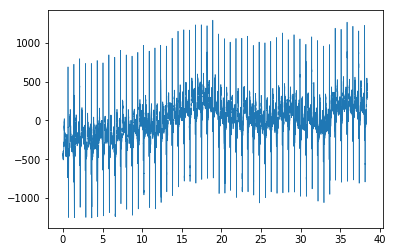

In [4]:
plt.plot(X, raw_signal, linewidth=0.7)
plt.show()

Actually, yes. The ECG belongs to a patient with myocardial ischemia. But that's not the reason there is that strange wandering in the signal! In fact, it's good for the patient it's there...

This wandering is called **baseline wandering** (_BW_) and is visible due to inevitable patient movements, biggest of which is certainly _breathing_. You might notice that this is a very low-frequency noise corresponding to a frequency with which people breathe (duh...).

To remove such wandering, one might filter it out with help of **Discrete Wavelet Transform**. The technique has gained much attention lately in biosignal processing. If you're interested on details how exactly does DWT work, _Just Google It_&trade;.

In the package there are implemented functions to filter out BW with DWT using one of two wavelets, proven to be effective in the task: _symmlet-10_ or _daubechies-2_, on level 10.

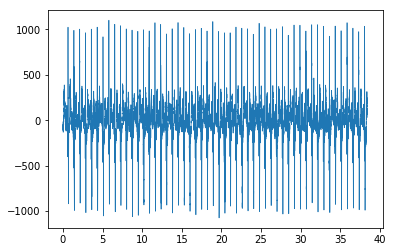

In [5]:
new_signal = prep.remove_baseline_wandering_s(raw_signal)
plt.plot(X, new_signal, linewidth=0.7)
plt.show()

See? The wandering is gone. May it help improve the diagnosis!

Let's prove that only low-frequency noise is removed that way. It's actually pretty easy.

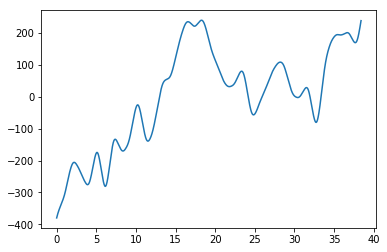

In [6]:
diff = raw_signal - new_signal
plt.plot(X, diff)
plt.show()

On the plot above you may see a part of the signal that got filtered out. No high-frequency components indeed! We may assume that most of the BW has been removed.

You can also do this for a whole record at once!

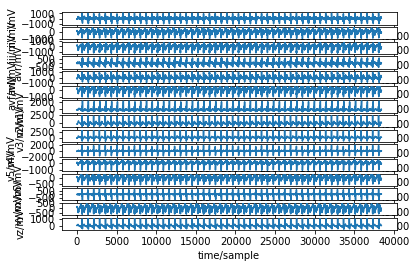

In [7]:
new_record = prep.remove_baseline_wandering(raw_record)
wfdb.plot_wfdb(new_record)

Another function you may find useful is `recslice` to retrieve only a part of each signal from record.

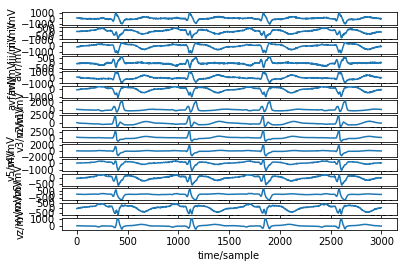

In [8]:
sliced = prep.recslice(new_record, sampfrom=1000, sampto=4000)
wfdb.plot_wfdb(sliced)

## `preprocessing.remove_baseline_wandering`

Remove BW from whole `wfdb.Record` instance in-place.

In [9]:
help(prep.remove_baseline_wandering)

Help on function remove_baseline_wandering in module cardiovector.preprocessing:

remove_baseline_wandering(record, wavelet_level=None)
    Filter BW from a `wfdb.Record` instance using a DWT algorithm. Wavelet to use is chosen using
    `choose_wavelet` function, unless custom is provided in `wavelet_level` arg.
    
    Parameters
    ----------
    record : wfdb.Record
        WFDB Record to filter.
    wavelet_level : tuple (wavelet : str, level : int), optional
        Tuple containing fallback wavelet name and desired decomposition level to use for filtering.
    
    Returns
    -------
    out_record : wfdb.Record
        Filtered record.



## `preprocessing.remove_baseline_wandering_s`

Remove BW from a single array-like signal. Returns a new array.

In [10]:
help(prep.remove_baseline_wandering_s)

Help on function remove_baseline_wandering_s in module cardiovector.preprocessing:

remove_baseline_wandering_s(signal, wavelet_level=None)
    Filter BW from a array-like signal using a DWT algorithm. Wavelet to use is chosen using `choose_wavelet` function,
    unless custom is provided in `wavelet_level` arg.
    
    Parameters
    ----------
    signal : (N,) array_like
        ECG signal to filter.
    wavelet_level : tuple (wavelet : str, level : int), optional
        Tuple containing fallback wavelet name and desired decomposition level to use for filtering.
    
    Returns
    -------
    out_signal : (N,) numpy.array
        Filtered signal.



## `preprocessing.choose_wavelet`

Let the package choose the best (contrary to the package) wavelet for filtering.

In [11]:
help(prep.choose_wavelet)

Help on function choose_wavelet in module cardiovector.preprocessing:

choose_wavelet(signal_length, fallback=None)
    Make a decision on to which wavelet should be used for BW filtering. If no decision can be made, due to not enough
    data samples, `fallback` will be returned if available.
    
    Currently there are two wavelets considered, both at 10th level of decomposition: symmlet-10 and daubechies-2.
    Both were proven effective for BW filtering (@Bunluechokchai2010, @Maheshwari16).
    
    Parameters
    ----------
    signal_length : int
        Number of samples in the signal to process.
    fallback : (wavelet : str, level : int), optional
        Tuple containing fallback wavelet name and desired decomposition level to return of none of wavelets included
        in the package are available.
    
    Returns
    -------
    wavelet_level : (wavelet : str, level : int)
        Tuple containing name and desired level of selected wavelet to use for filtering.



## `preprocessing.recslice`

Retrieve a part of the record.

In [12]:
help(prep.recslice)

Help on function recslice in module cardiovector.preprocessing:

recslice(record, sampfrom=None, sampto=None)
    Slice the record to leave only a part of the signal.
    
    Parameters
    ----------
    record : wfdb.Record
        Record to modify.
    sampfrom : int, optional
        First sample (inclusive) to include in modified record.
    sampto : int, optional
        Last sample (exclusive) of the modified record.
    Returns
    -------
    record : wfdb.Record
        The modified record.

